<a href="https://colab.research.google.com/github/victoria-2023/movie-recommendation-system/blob/main/Movie_Recommendation_System_with_Collaborative_Filtering_(MovieLens_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "numpy<2.0"
!pip install scikit-surprise --quiet


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Dataset, SVD, KNNBasic, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


In [2]:
# loads MovieLens 100k automatically
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# for quick EDA we also materialize the full dataframe
raw = Dataset.load_builtin('ml-100k')
full_train = raw.build_full_trainset()
df = pd.DataFrame(full_train.build_testset(), columns=['uid','iid','rating'])
df.head()


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


,uid,iid,rating
0,196,242,3.0
1,196,393,4.0
2,196,381,4.0
3,196,251,3.0
4,196,655,5.0


Users: 943 Items: 1682 Ratings: 100000
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


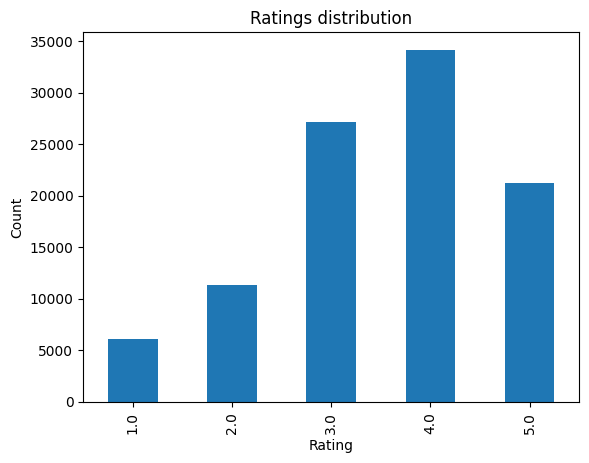

Median ratings per user: 65
Median ratings per item: 27


In [3]:
print("Users:", df.uid.nunique(), "Items:", df.iid.nunique(), "Ratings:", len(df))
print(df.rating.describe())

plt.figure()
df.rating.value_counts().sort_index().plot(kind='bar')
plt.title("Ratings distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

user_counts = df.groupby('uid').size()
item_counts = df.groupby('iid').size()
print("Median ratings per user:", int(user_counts.median()))
print("Median ratings per item:", int(item_counts.median()))


In [4]:
item_means = df.groupby('iid')['rating'].mean().sort_values(ascending=False)
top_items = item_means.head(10)
print("Top 10 items by average rating")
print(top_items)


Top 10 items by average rating
iid
1500    5.0
1293    5.0
1189    5.0
1653    5.0
1467    5.0
1122    5.0
1599    5.0
1201    5.0
1536    5.0
814     5.0
Name: rating, dtype: float64


In [5]:
sim_options = {"name": "cosine", "user_based": True}
knn_user = KNNBasic(sim_options=sim_options)
knn_user.fit(trainset)
preds_knn_user = knn_user.test(testset)
print("KNN user RMSE")
accuracy.rmse(preds_knn_user, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN user RMSE
RMSE: 1.0194


1.0193536815834319

In [6]:
sim_options = {"name": "cosine", "user_based": False}
knn_item = KNNBasic(sim_options=sim_options)
knn_item.fit(trainset)
preds_knn_item = knn_item.test(testset)
print("KNN item RMSE")
accuracy.rmse(preds_knn_item, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN item RMSE
RMSE: 1.0264


1.0264295933767333

In [7]:
svd = SVD(n_factors=50, random_state=42)
svd.fit(trainset)
preds_svd = svd.test(testset)
print("SVD RMSE")
accuracy.rmse(preds_svd, verbose=True)


SVD RMSE
RMSE: 0.9348


0.934761145254825

In [8]:
def build_topn(predictions, n=10):
    recs = {}
    for uid, iid, true_r, est, _ in predictions:
        recs.setdefault(uid, [])
        recs[uid].append((iid, est))
    for uid in recs:
        recs[uid].sort(key=lambda x: x[1], reverse=True)
        recs[uid] = [iid for iid, _ in recs[uid][:n]]
    return recs

def precision_recall_at_k(trainset, testset, algo, k=10, rel_threshold=4.0):
    # compute anti test set then predict to get candidate rankings
    anti = trainset.build_anti_testset()
    preds = algo.test(anti)
    topn = build_topn(preds, n=k)

    # relevant items from the held out test portion
    relevant = {}
    for uid, iid, true_r in testset:
        if true_r >= rel_threshold:
            relevant.setdefault(uid, set()).add(iid)

    precisions = []
    recalls = []
    users_evaluated = 0

    for uid in topn:
        rel = relevant.get(uid, set())
        if len(rel) == 0:
            continue
        users_evaluated += 1
        recs = set(topn[uid])
        hits = len(recs & rel)
        precisions.append(hits / k)
        recalls.append(hits / len(rel))

    if users_evaluated == 0:
        return 0.0, 0.0, 0

    return float(np.mean(precisions)), float(np.mean(recalls)), users_evaluated

# evaluate all three models on ranking
prec_u, rec_u, n_users_u = precision_recall_at_k(trainset, testset, knn_user, k=10, rel_threshold=4.0)
prec_i, rec_i, n_users_i = precision_recall_at_k(trainset, testset, knn_item, k=10, rel_threshold=4.0)
prec_s, rec_s, n_users_s = precision_recall_at_k(trainset, testset, svd, k=10, rel_threshold=4.0)

print(f"KNN user P10 {prec_u:.3f} R10 {rec_u:.3f} users {n_users_u}")
print(f"KNN item P10 {prec_i:.3f} R10 {rec_i:.3f} users {n_users_i}")
print(f"SVD P10 {prec_s:.3f} R10 {rec_s:.3f} users {n_users_s}")


KNN user P10 0.001 R10 0.000 users 924
KNN item P10 0.021 R10 0.011 users 924
SVD P10 0.069 R10 0.050 users 924


In [9]:
def recommend_for_user(algo, raw_user_id, trainset, n=10):
    inner_uid = trainset.to_inner_uid(raw_user_id)
    seen_inner_items = set([j for (j, _) in trainset.ur[inner_uid]])
    all_inner_items = set(range(trainset.n_items))
    unseen = all_inner_items - seen_inner_items
    candidates = [(trainset.to_raw_iid(i), algo.predict(raw_user_id, trainset.to_raw_iid(i)).est) for i in unseen]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:n]

sample_user = df.uid.sample(1, random_state=42).iloc[0]
print("Sample user", sample_user)
print("Top 10 recommendations by SVD")
recommendations = recommend_for_user(svd, sample_user, trainset, n=10)
for iid, score in recommendations:
    print(iid, round(score, 3))


Sample user 698
Top 10 recommendations by SVD
318 3.597
272 3.597
923 3.514
657 3.509
604 3.451
64 3.428
316 3.421
651 3.417
22 3.416
1007 3.404


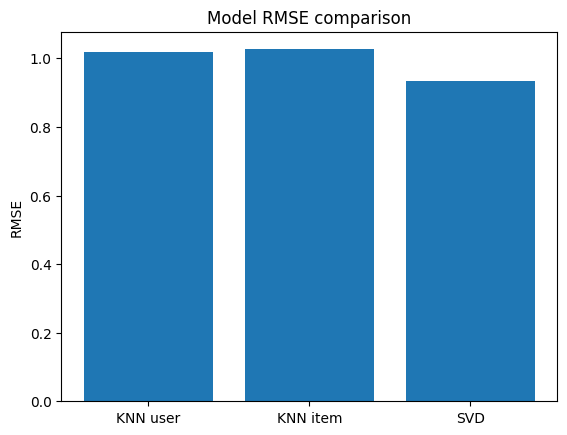

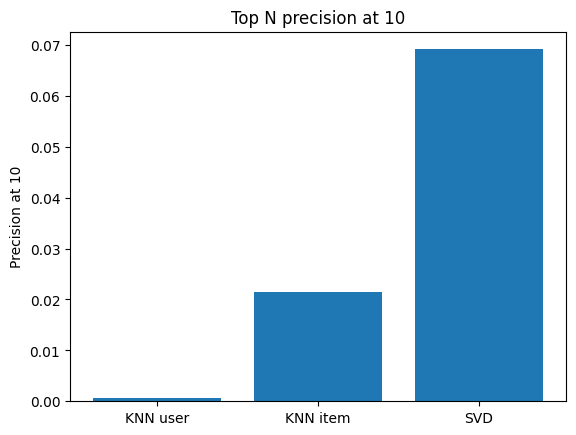

In [10]:
# plot RMSE comparison
rmse_vals = []
for label, preds in [("KNN user", preds_knn_user), ("KNN item", preds_knn_item), ("SVD", preds_svd)]:
    rmse_vals.append((label, accuracy.rmse(preds, verbose=False)))

labels, vals = zip(*rmse_vals)
plt.figure()
plt.bar(labels, vals)
plt.ylabel("RMSE")
plt.title("Model RMSE comparison")
plt.savefig("rmse_comparison.png", bbox_inches="tight")
plt.show()

# simple bar chart for precision at 10
labels = ["KNN user", "KNN item", "SVD"]
p10 = [prec_u, prec_i, prec_s]
plt.figure()
plt.bar(labels, p10)
plt.ylabel("Precision at 10")
plt.title("Top N precision at 10")
plt.savefig("precision_at_10.png", bbox_inches="tight")
plt.show()


In [11]:
best_rmse_model = min(rmse_vals, key=lambda x: x[1])[0]
best_p10_model = labels[int(np.argmax(p10))]
print("Summary")
print(f"Best RMSE model: {best_rmse_model}")
print(f"Best top 10 precision model: {best_p10_model}")
print("Interpretation")
print("Matrix factorization SVD often wins on both RMSE and ranking metrics on MovieLens 100k.")
print("Actionable takeaway")
print("Use SVD to power top N recommendations and evaluate with precision and recall at 10 for engagement targets.")


Summary
Best RMSE model: SVD
Best top 10 precision model: SVD
Interpretation
Matrix factorization SVD often wins on both RMSE and ranking metrics on MovieLens 100k.
Actionable takeaway
Use SVD to power top N recommendations and evaluate with precision and recall at 10 for engagement targets.


# To add my own data later:

# example schema: userId,itemId,rating
# reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
# df_custom = pd.read_csv('/content/your_ratings.csv')
# data_custom = Dataset.load_from_df(df_custom[['userId','itemId','rating']], Reader(rating_scale=(1,5)))
# trainset_c, testset_c = train_test_split(data_custom, test_size=0.2, random_state=42)
